In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [3]:
# Load & prepare data
data_path = "../data/E-commerce data.csv"
df = pd.read_csv(data_path, encoding="ISO-8859-1")

In [4]:
df = df.dropna(subset=["CustomerID"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df["CustomerID"] = df["CustomerID"].astype(int)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["TotalSpent"] = df["Quantity"] * df["UnitPrice"]

In [5]:
# RFM
snapshot = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot - x.max()).days,
    "InvoiceNo": "count",
    "TotalSpent": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

In [6]:
# Scaling data
rfm_log = np.log1p(rfm)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

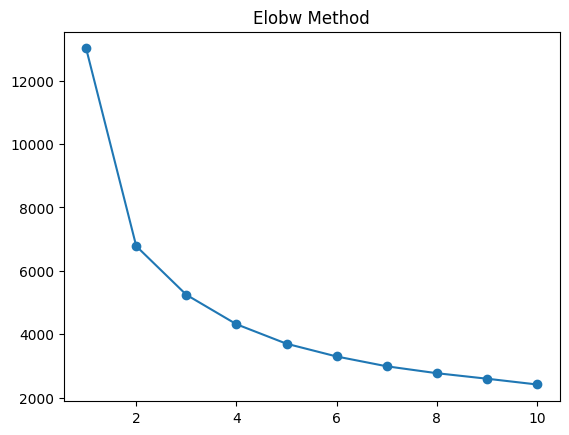

In [7]:
# Elbow
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elobw Method")
plt.show()

In [8]:
# Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [9]:
def segment_label(c):
    return{
        0: "At Risk",
        1: "Loyal Customers",
        2: "Big Spenders",
        3: "New / Occasional"
    }[c]

rfm['Segment'] = rfm['Cluster'].map(segment_label)
rfm.head()

,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346,326,1,77183.60,1,Loyal Customers
12347,2,182,4310.00,2,Big Spenders
12348,75,31,1797.24,1,Loyal Customers
12349,19,73,1757.55,1,Loyal Customers
12350,310,17,334.40,3,New / Occasional


In [10]:
# Revenue share
revenue_share = (
    rfm.groupby("Segment")["Monetary"].sum()
    / rfm["Monetary"].sum()
)

revenue_share


Segment
At Risk             0.057009
Big Spenders        0.686191
Loyal Customers     0.211067
New / Occasional    0.045732
Name: Monetary, dtype: float64

In [11]:
# Segment-level statistics
segment_stats = rfm.groupby("Segment").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": ["mean", "sum", "count"]
}).round(2)

segment_stats


Recency Frequency Monetary                  
                    mean      mean     mean         sum count
Segment                                                      
At Risk            20.41     37.12   588.00   508034.19   864
Big Spenders       12.85    281.41  6996.49  6114930.46   874
Loyal Customers    94.34     80.11  1515.64  1880903.76  1241
New / Occasional  187.99     15.04   299.88   407539.49  1359

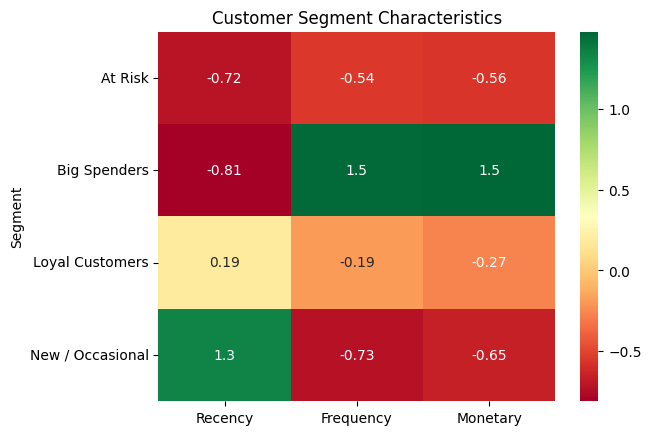

In [12]:
# Heatmap
norm = (segment_stats.xs("mean", level=1, axis=1) -
        segment_stats.xs("mean", level=1, axis=1).mean()) / \
        segment_stats.xs("mean", level=1, axis=1).std()

sns.heatmap(norm, annot=True, cmap="RdYlGn")
plt.title("Customer Segment Characteristics")
plt.show()
